# Auto generated report for all zones

This notebook generates for each available geographic zone a summary of the most recent simulation.


## Preparation

### Loading libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, Markdown, Latex

In [3]:
import os
from functools import partial

In [4]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
from numpy import unique

In [5]:
from model_analysis import * 

### Loading data

In [6]:
run_manifest = read_manifest('run-manifest.csv')
analysis_set = get_analysis_set(run_manifest)

In [7]:
def add_to_zone_dict(zone_dict, row, i, zone):
    zone_dict[zone] = {
        "index": i,
        "date": row["last available data"],
        "version": row["version"],
    }

zone_dict = {}
for i, row in analysis_set.iterrows():
    for zone in row["modelling zones"]:
        if zone not in zone_dict:
            add_to_zone_dict(zone_dict, row, i, zone)
        elif (zone_dict[zone]["date"] < row["last available data"])\
            or (zone_dict[zone]["date"] == row["last available data"]
                and zone_dict[zone]["version"] < row["version"]):
            add_to_zone_dict(zone_dict, row, i, zone)
        

In [8]:
indices = unique([zone_dict[d]['index'] for d in zone_dict])
country_2_region = {}
for idx in indices:
    for country in analysis_set.loc[idx,].model.data['ifr']['country'].unique():
        country_2_region[country] = {}

    for _, row in analysis_set.loc[idx,].model.data['ifr'].iterrows():
        country_2_region[row['country']][row['region']] = zone_dict[row['region']]['index']


## Plotting functions

First we define a custom process that will print for each zone.

In [9]:
def process_zone(zone, zone_dict, model_data, title_ext=""):
    display(Markdown(
        f"### {zone}{title_ext} \n\n Latest simulation on data from {zone_dict['date']}"
        + f" with version {zone_dict['version']}"
    ))
    axs = plot_zones_summary(zone, model_data)
    axis_date_limits(axs, max_date='2020-06-01')
    plt.show()
    plt.close()

In [10]:
def print_zone(file_in, img_dir, file_dir, zone, zone_dict, model_data, title_ext="", img_ext=".png"):
    img_file = os.path.join(img_dir, (zone + '_' + zone_dict['date'].strip() + img_ext).replace(" ", "_"))
    
    unix_rel_img_path = os.path.relpath(img_file, file_dir).replace('\\','/')
    file_in.write(
        f"### {zone}{title_ext} \n\n Latest simulation on data from {zone_dict['date']}"
        + f" with version {zone_dict['version']} \n\n ![img_file]({unix_rel_img_path})\n\n"
    )
    axs = plot_zones_summary(zone, model_data)
    axis_date_limits(axs, max_date='2020-06-01')
    axs[0].figure.savefig(img_file, bbox_inches='tight')
    plt.close(axs[0].figure)

And then we apply this function to every zone that has been identified.

In [12]:
def apply_process_to_data(
    process_func, country_2_region, analysis_set, zone_dict,
    display_func=lambda x:display(Markdown(x))):
    display_func("# Country reports\n")
    for country in country_2_region:
        display_func(f"## {country}\n")
        if country in country_2_region[country]:
            idx = zone_dict[country]['index']
            process_func(
                country, zone_dict[country], 
                analysis_set.loc[idx, 'model'].data,
                title_ext=" - (country)")
        
        for zone in sorted([z for z in country_2_region[country]]):
            if zone != country:
                idx = zone_dict[zone]['index']
                process_func(
                    zone, zone_dict[zone], 
                    analysis_set.loc[idx, 'model'].data)
                break
        break

# Country reports


## France


### France - (country) 

 Latest simulation on data from  2020-05-10  with version  v3

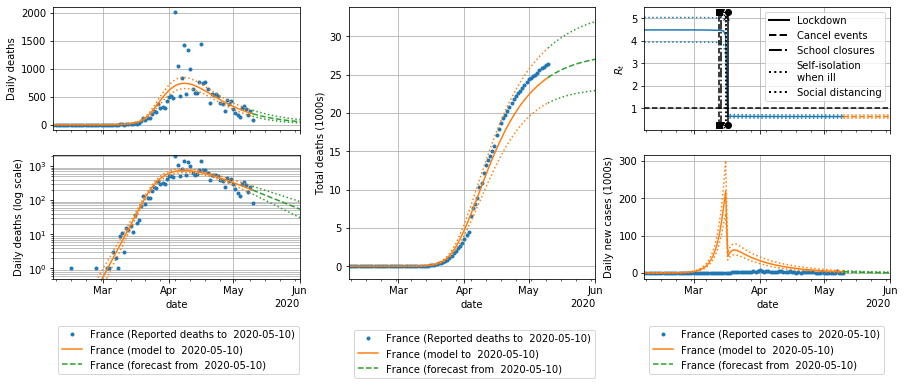

### Auvergne-Rhône-Alpes 

 Latest simulation on data from  2020-05-10  with version  v3

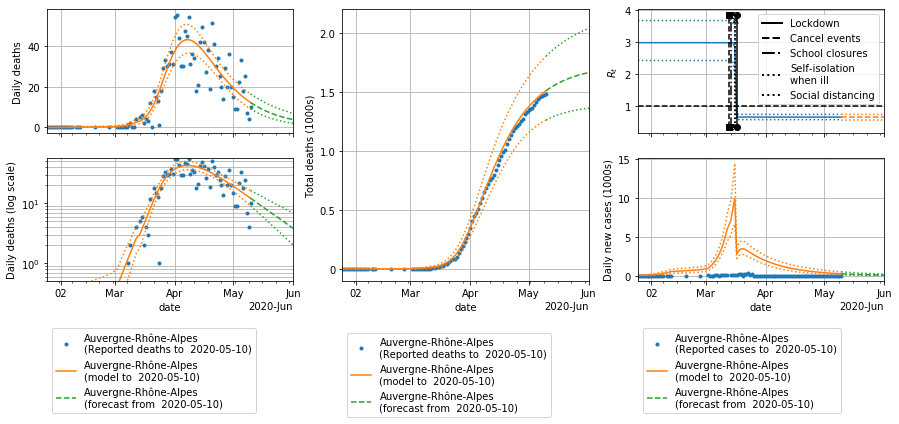

In [15]:
apply_process_to_data(process_zone, country_2_region, analysis_set, zone_dict)

In [12]:
report_dir = os.path.join('reports', 'all_zone_report')
img_dir = os.path.join(report_dir, 'img')
os.makedirs(report_dir, exist_ok=True)
os.makedirs(img_dir, exist_ok=True)
report_file = os.path.join(report_dir, "all_zone_report.md")
with open(report_file, "w", encoding="utf-8") as file_in:
    print_partial = partial(print_zone, file_in, img_dir, report_dir)
    apply_process_to_data(
        print_partial, country_2_region, analysis_set, zone_dict,
        file_in.write)

analysis_set